In [1]:
import numpy as np
import pandas as pd

In [2]:
import yfinance as yf

df = yf.download('NVDA', start="2010-01-01")
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,4.627500,4.655000,4.527500,4.622500,4.240229,80020400
2010-01-05,4.605000,4.740000,4.605000,4.690000,4.302146,72864800
2010-01-06,4.687500,4.730000,4.642500,4.720000,4.329666,64916800
2010-01-07,4.695000,4.715000,4.592500,4.627500,4.244817,54779200
2010-01-08,4.590000,4.670000,4.562500,4.637500,4.253988,47816800
...,...,...,...,...,...,...
2024-04-05,868.659973,884.809998,859.260010,880.080017,880.080017,39885700
2024-04-08,887.000000,888.299988,867.320007,871.330017,871.330017,28322000
2024-04-09,874.419983,876.349976,830.219971,853.539978,853.539978,50354700


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df[['Close']].values)

In [4]:
scaled_df

array([[0.00253482],
       [0.00260604],
       [0.00263769],
       ...,
       [0.89820633],
       [0.91598438],
       [0.95372437]])

In [5]:
# Define parameters
n_hidden_units = 128
input_length = 100
output_length = 20
dropout_rate = 0.2
n_features = 1

In [6]:
# Create time series batches
X, Y = [], []
for i in range(len(scaled_df) - input_length - output_length + 1):
    X.append(scaled_df[i:i+input_length])
    Y.append(scaled_df[i+input_length:i+input_length+output_length])

X = np.array(X)
Y = np.array(Y)

In [7]:
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense


# Define GRU model
model = Sequential()

model.add(GRU(units=n_hidden_units, input_shape=(input_length, n_features), return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(GRU(units=n_hidden_units))
model.add(Dropout(dropout_rate))
model.add(Dense(units=output_length))

model.compile(optimizer='adam', loss='mse')

c:\Users\j584l\Downloads\Projects\stock-price-forecasting\env1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.fit(X, Y, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 7.9644e-04 - val_loss: 0.0019
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 8.1289e-05 - val_loss: 0.0021
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 5.9189e-05 - val_loss: 0.0027
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: 6.2621e-05 - val_loss: 0.0024
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 4.7474e-05 - val_loss: 0.0018
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - loss: 4.9257e-05 - val_loss: 0.0021
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - loss: 5.9294e-05 - val_loss: 0.0015
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 4.6884e-05 - val_loss: 0.0020
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: 4.4785e-05 - val_loss: 0.0016
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - loss: 4.3299e-05 - val_loss: 0.0016
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - loss: 3.9603e-05 - val_loss: 0.00

In [ ]:
# Predictions
def predict_all(model, data, input_length, output_length):
    predictions = []
    for i in range(len(data) - input_length + 1):
        input_data = data[i:i+input_length].reshape(1, input_length, n_features)
        pred = model.predict(input_data).reshape(output_length)
        predictions.append(pred)
    return np.array(predictions)

scaled_preds = predict_all(model, scaled_df, input_length, output_length)
preds = scaler.inverse_transform(scaled_preds)

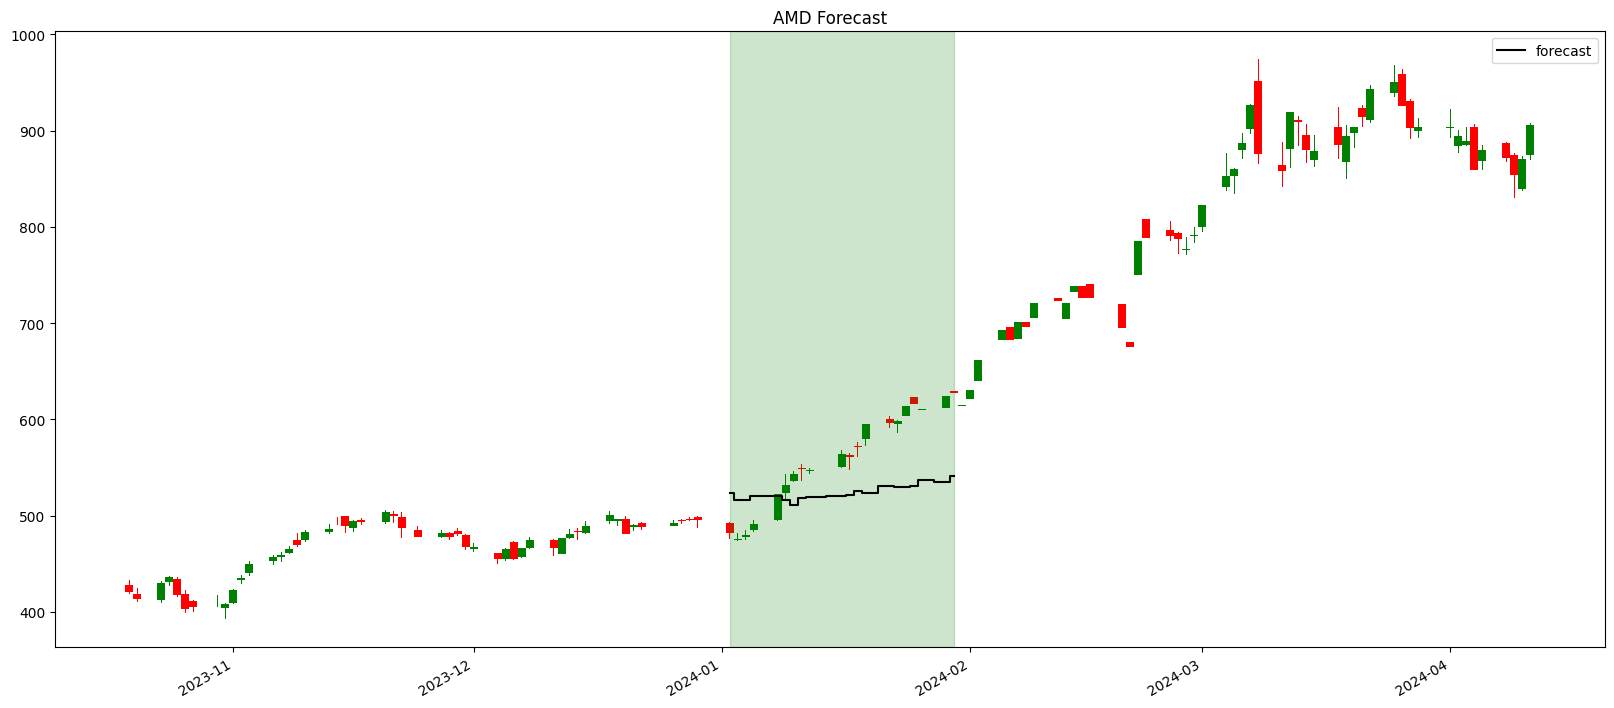

In [16]:
import matplotlib.pyplot as plt 

candles_back = 50
lpadding = 50
rpadding = 50

rlim = rpadding-candles_back if candles_back > rpadding else None

df_display = df.iloc[-lpadding-output_length-candles_back:rlim]

up = df_display[df_display['Close'] >= df_display['Open']]
down = df_display[df_display['Close'] < df_display['Open']] 
col1 = 'green'
col2 = 'red'
width = 1
width2 = .1


plt.figure(figsize=(20,8))

# Plotting up prices of the stock 
plt.bar(up.index, up['Close']-up['Open'], width, bottom=up['Open'], color=col1) 
plt.bar(up.index, up['High']-up['Close'], width2, bottom=up['Close'], color=col1) 
plt.bar(up.index, up['Low']-up['Open'], width2, bottom=up['Open'], color=col1) 
  
# Plotting down prices of the stock 
plt.bar(down.index, down['Close']-down['Open'], width, bottom=down['Open'], color=col2) 
plt.bar(down.index, down['High']-down['Open'], width2, bottom=down['Open'], color=col2) 
plt.bar(down.index, down['Low']-down['Close'], width2, bottom=down['Close'], color=col2) 
  
plt.step(df_display.index[lpadding:lpadding+output_length], preds[-output_length-candles_back-1], where='mid', label='forecast', color='black')

# rotating the x-axis tick labels at 30degree  
plt.xticks(rotation=30, ha='right') 
  
plt.legend()
plt.title('AMD Forecast')

plt.axvspan(df_display.index[lpadding], df_display.index[lpadding+output_length-1], color='green', alpha=0.2)
  
plt.show() 